In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

# 5 SKUs, 2 years daily data
dates = pd.date_range("2022-01-01", "2023-12-31", freq="D")
sku_list = ["SKU_A", "SKU_B", "SKU_C", "SKU_D", "SKU_E"]

rows = []
for sku in sku_list:
    base = np.random.randint(50, 150)
    trend = np.linspace(0, np.random.randint(10, 60), len(dates))
    weekly = 5 * np.sin(2 * np.pi * np.arange(len(dates)) / 7)
    noise = np.random.normal(0, 8, len(dates))

    # each SKU gets its own shape
    demand = base + trend + weekly + noise
    demand = np.maximum(demand, 0)

    for d, y in zip(dates, demand):
        rows.append({
            "date": d,
            "sku": sku,
            "demand": round(y)
        })

df = pd.DataFrame(rows)
df.head()


,date,sku,demand
0,2022-01-01,SKU_A,105
1,2022-01-02,SKU_A,100
2,2022-01-03,SKU_A,96
3,2022-01-04,SKU_A,120
4,2022-01-05,SKU_A,98


In [2]:
# Feature creation: lag1, MA7, day-of-week
df = df.sort_values(["sku", "date"])

df["dow"] = df["date"].dt.dayofweek

df["demand_lag1"] = df.groupby("sku")["demand"].shift(1)
df["demand_ma7"]  = df.groupby("sku")["demand"].shift(1).rolling(7).mean().reset_index(level=0, drop=True)

df2 = df.dropna().reset_index(drop=True)
df2.head()


,date,sku,demand,dow,demand_lag1,demand_ma7
0,2022-01-08,SKU_A,98,5,90.0,99.714286
1,2022-01-09,SKU_A,101,6,98.0,98.714286
2,2022-01-10,SKU_A,108,0,101.0,98.857143
3,2022-01-11,SKU_A,106,1,108.0,100.571429
4,2022-01-12,SKU_A,100,2,106.0,98.571429


In [3]:
cutoff_date = df2["date"].max() - pd.Timedelta(days=60)

train = df2[df2["date"] < cutoff_date]
test  = df2[df2["date"] >= cutoff_date]

print(len(train), len(test))


3310 305


In [4]:
# One-hot encode SKU
df2_encoded = pd.get_dummies(df2, columns=["sku"], drop_first=False)

# Split encoded version
train = df2_encoded[df2_encoded["date"] < cutoff_date]
test  = df2_encoded[df2_encoded["date"] >= cutoff_date]

# Features
feature_cols = ["demand_lag1", "demand_ma7", "dow"] + [c for c in df2_encoded.columns if c.startswith("sku_")]

X_train = train[feature_cols]
y_train = train["demand"]

X_test = test[feature_cols]
y_test = test["demand"]

feature_cols


['demand_lag1',
 'demand_ma7',
 'dow',
 'sku_SKU_A',
 'sku_SKU_B',
 'sku_SKU_C',
 'sku_SKU_D',
 'sku_SKU_E']

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_multi = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_multi.fit(X_train, y_train)

rf_preds = rf_multi.predict(X_test)


In [6]:
from sklearn.metrics import mean_absolute_error

# Make a safe copy
test = test.copy()

# Add predictions
test.loc[:, "pred"] = rf_preds

# Reattach the original 'sku' column using the same indices
test.loc[:, "sku"] = df2.loc[test.index, "sku"].values

# group by sku
sku_scores = test.groupby("sku").apply(
    lambda g: mean_absolute_error(g["demand"], g["pred"])
).reset_index(name="MAE")

sku_scores



C:\Users\Elijah Samuel\AppData\Local\Temp\ipykernel_24336\949541419.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sku_scores = test.groupby("sku").apply(


,sku,MAE
0,SKU_A,9.825671
1,SKU_B,7.410334
2,SKU_C,7.424914
3,SKU_D,6.180273
4,SKU_E,6.597780


In [7]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# test already has: 'demand', 'pred', 'sku'
sku_scores = (
    test.groupby("sku")
    .apply(lambda g: pd.Series({
        "MAE": mean_absolute_error(g["demand"], g["pred"]),
        "MAPE (%)": mape(g["demand"], g["pred"]),
        "Mean demand": g["demand"].mean()
    }))
    .reset_index()
    .sort_values("MAE")
)

sku_scores


C:\Users\Elijah Samuel\AppData\Local\Temp\ipykernel_24336\4160144069.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,sku,MAE,MAPE (%),Mean demand
3,SKU_D,6.180273,6.107790,98.180328
4,SKU_E,6.597780,6.714880,98.049180
1,SKU_B,7.410334,9.065182,81.803279
2,SKU_C,7.424914,6.021391,123.524590
0,SKU_A,9.825671,7.072408,137.442623


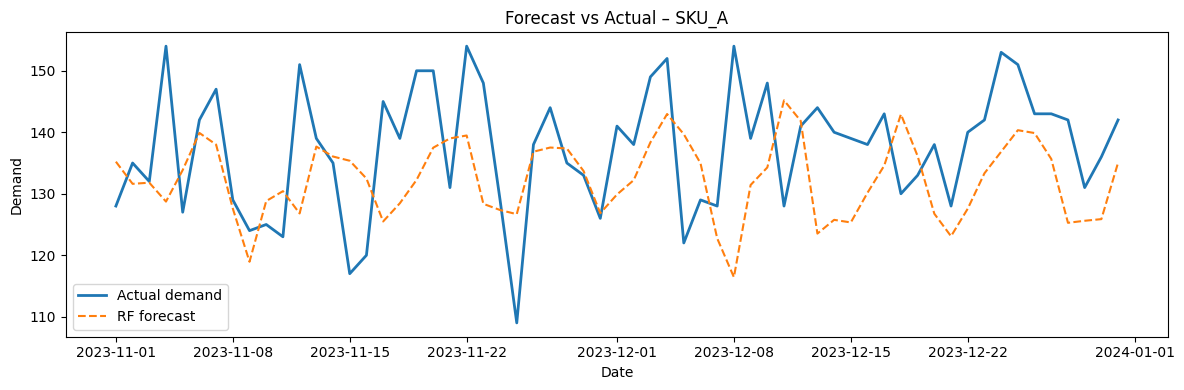

In [8]:
import matplotlib.pyplot as plt

# Pick a SKU to inspect
sku_to_plot = "SKU_A"  # change to any SKU in sku_list

df_plot = test[test["sku"] == sku_to_plot].sort_values("date")

plt.figure(figsize=(12, 4))
plt.plot(df_plot["date"], df_plot["demand"], label="Actual demand", linewidth=2)
plt.plot(df_plot["date"], df_plot["pred"], label="RF forecast", linestyle="--")
plt.title(f"Forecast vs Actual – {sku_to_plot}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.tight_layout()
plt.show()


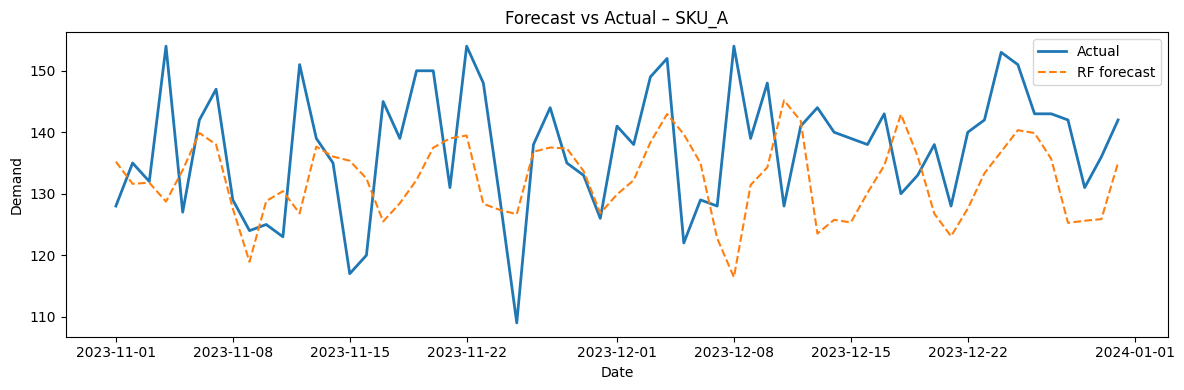

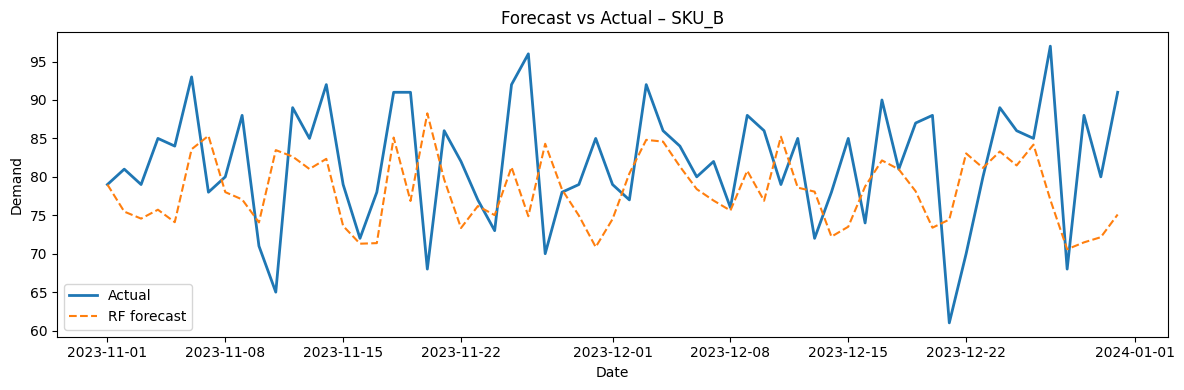

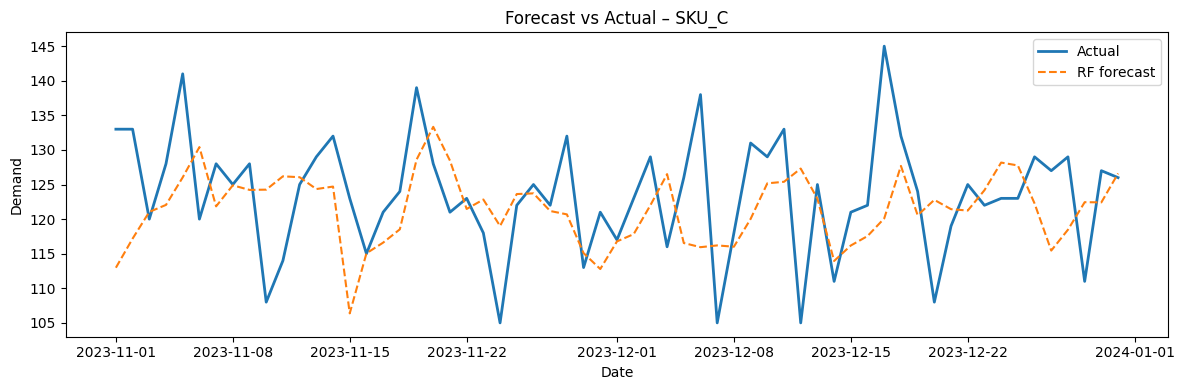

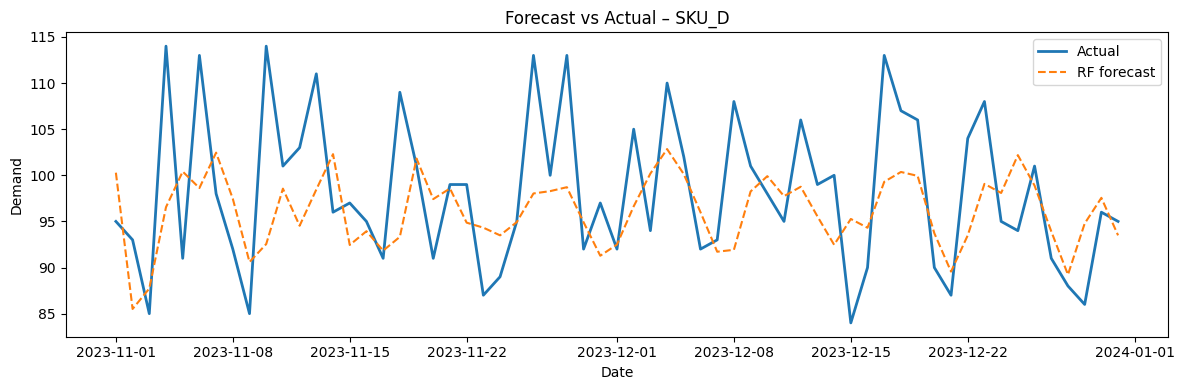

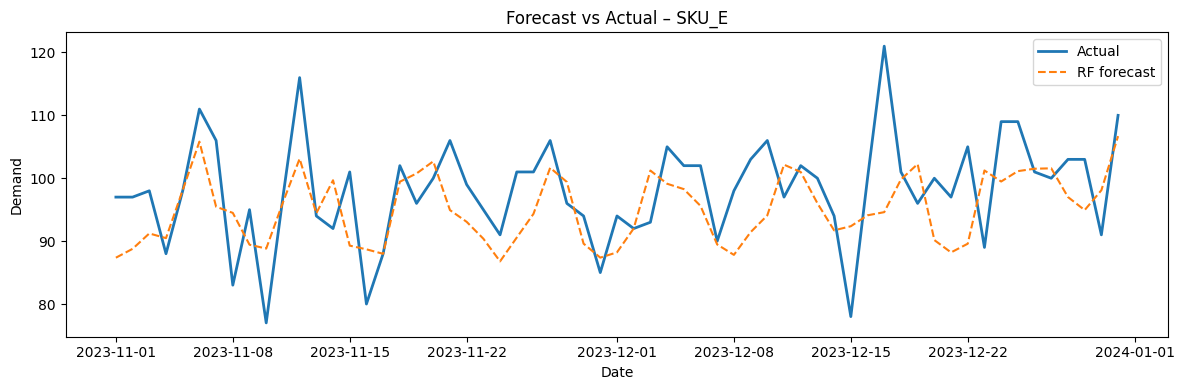

In [9]:
for sku_name in sorted(test["sku"].unique()):
    df_plot = test[test["sku"] == sku_name].sort_values("date")

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["date"], df_plot["demand"], label="Actual", linewidth=2)
    plt.plot(df_plot["date"], df_plot["pred"], label="RF forecast", linestyle="--")
    plt.title(f"Forecast vs Actual – {sku_name}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
feature_importances_multi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_multi.feature_importances_
}).sort_values("importance", ascending=False)

feature_importances_multi


,feature,importance
1,demand_ma7,0.897497
0,demand_lag1,0.052184
2,dow,0.036943
4,sku_SKU_B,0.003441
6,sku_SKU_D,0.002982
5,sku_SKU_C,0.002540
7,sku_SKU_E,0.002472
3,sku_SKU_A,0.001940


In [11]:
# Reattach the original 'sku' column using df2 (which still has it)

train = train.copy()
test = test.copy()

train.loc[:, "sku"] = df2.loc[train.index, "sku"].values
test.loc[:, "sku"] = df2.loc[test.index, "sku"].values


In [12]:
from sklearn.ensemble import RandomForestRegressor

sku_models = {}
sku_predictions = []

sku_list = sorted(df2["sku"].unique())

for sku_name in sku_list:
    # Filter train/test for this SKU only
    train_sku = train[train["sku"] == sku_name]
    test_sku  = test[test["sku"] == sku_name]

    X_train_sku = train_sku[["demand_lag1", "demand_ma7", "dow"]]
    y_train_sku = train_sku["demand"]

    X_test_sku = test_sku[["demand_lag1", "demand_ma7", "dow"]]
    y_test_sku = test_sku["demand"]

    rf_sku = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42
    )
    rf_sku.fit(X_train_sku, y_train_sku)

    sku_models[sku_name] = rf_sku

    preds = rf_sku.predict(X_test_sku)

    temp_df = pd.DataFrame({
        "sku": sku_name,
        "date": test_sku["date"],
        "actual": y_test_sku.values,
        "pred_sku_model": preds
    })

    sku_predictions.append(temp_df)

sku_predictions_df = pd.concat(sku_predictions).reset_index(drop=True)
sku_predictions_df.head()


,sku,date,actual,pred_sku_model
0,SKU_A,2023-11-01,128,135.759460
1,SKU_A,2023-11-02,135,130.979906
2,SKU_A,2023-11-03,132,132.767761
3,SKU_A,2023-11-04,154,126.732896
4,SKU_A,2023-11-05,127,133.845129


In [13]:
# Merge global model predictions (rf_preds) into SKU-specific results

test_global = test.copy()
test_global = test_global.reset_index()

# Add SKU, date, actual demand
test_global = test_global[["sku", "date", "demand", "pred"]].rename(
    columns={"demand": "actual", "pred": "pred_global"}
)

# Combine with per-SKU predictions
comparison_df = sku_predictions_df.merge(
    test_global,
    on=["sku", "date"],
    how="left"
)

comparison_df.head()


,sku,date,actual_x,pred_sku_model,actual_y,pred_global
0,SKU_A,2023-11-01,128,135.759460,128,135.214161
1,SKU_A,2023-11-02,135,130.979906,135,131.612857
2,SKU_A,2023-11-03,132,132.767761,132,131.799767
3,SKU_A,2023-11-04,154,126.732896,154,128.726661
4,SKU_A,2023-11-05,127,133.845129,127,133.855452


In [14]:
# Clean up duplicate 'actual' columns after merge

comparison_df = comparison_df.copy()

# If pandas created suffixed columns, normalize them
if "actual_x" in comparison_df.columns:
    comparison_df = comparison_df.rename(columns={"actual_x": "actual"})

if "actual_y" in comparison_df.columns:
    # Drop the second copy of actual
    comparison_df = comparison_df.drop(columns=["actual_y"])


In [15]:
from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

results = []

for sku_name in sku_list:
    df_sku = comparison_df[comparison_df["sku"] == sku_name]

    mae_global = mean_absolute_error(df_sku["actual"], df_sku["pred_global"])
    mae_sku    = mean_absolute_error(df_sku["actual"], df_sku["pred_sku_model"])

    mape_global = mape(df_sku["actual"], df_sku["pred_global"])
    mape_sku    = mape(df_sku["actual"], df_sku["pred_sku_model"])

    results.append({
        "SKU": sku_name,
        "MAE (Global)": mae_global,
        "MAE (Per-SKU)": mae_sku,
        "MAPE (Global)": mape_global,
        "MAPE (Per-SKU)": mape_sku
    })

results_df = pd.DataFrame(results).sort_values("MAE (Global)")
results_df


,SKU,MAE (Global),MAE (Per-SKU),MAPE (Global),MAPE (Per-SKU)
3,SKU_D,6.180273,6.350623,6.107790,6.266724
4,SKU_E,6.597780,7.881430,6.714880,7.905479
1,SKU_B,7.410334,7.686082,9.065182,9.380801
2,SKU_C,7.424914,8.053180,6.021391,6.431333
0,SKU_A,9.825671,9.635290,7.072408,6.933745


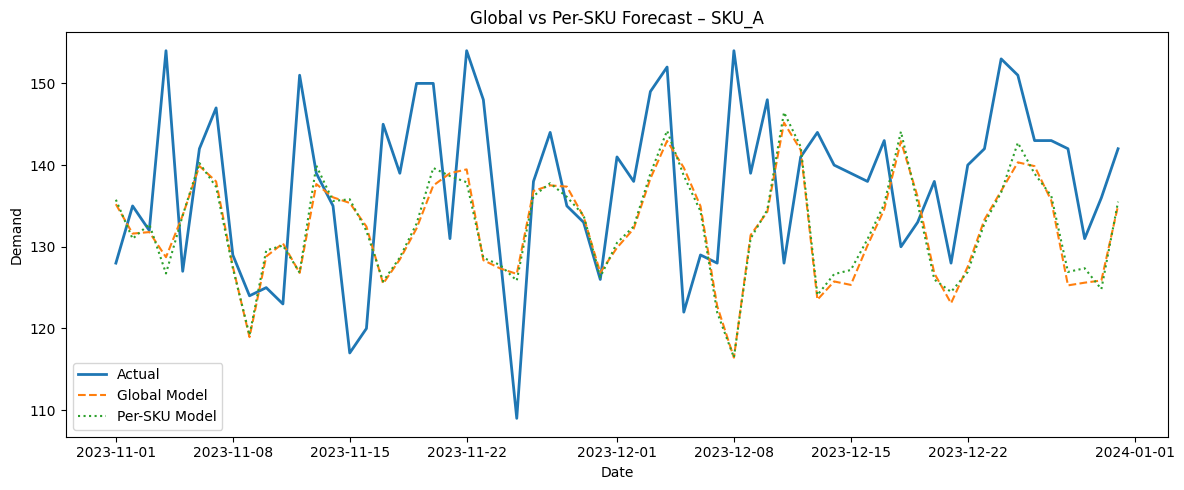

In [16]:
sku_to_plot = "SKU_A"

df_plot = comparison_df[comparison_df["sku"] == sku_to_plot].sort_values("date")

plt.figure(figsize=(12,5))
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linewidth=2)
plt.plot(df_plot["date"], df_plot["pred_global"], label="Global Model", linestyle="--")
plt.plot(df_plot["date"], df_plot["pred_sku_model"], label="Per-SKU Model", linestyle=":")
plt.title(f"Global vs Per-SKU Forecast – {sku_to_plot}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
results_df = results_df.copy()

# Which model has lower MAE?
results_df["Better Model (MAE)"] = np.where(
    results_df["MAE (Per-SKU)"] < results_df["MAE (Global)"],
    "Per-SKU",
    "Global"
)

# How much improvement does the better one have vs the other?
results_df["MAE Difference"] = results_df["MAE (Global)"] - results_df["MAE (Per-SKU)"]

results_df


,SKU,MAE (Global),MAE (Per-SKU),MAPE (Global),MAPE (Per-SKU),Better Model (MAE),MAE Difference
3,SKU_D,6.180273,6.350623,6.107790,6.266724,Global,-0.170350
4,SKU_E,6.597780,7.881430,6.714880,7.905479,Global,-1.283650
1,SKU_B,7.410334,7.686082,9.065182,9.380801,Global,-0.275748
2,SKU_C,7.424914,8.053180,6.021391,6.431333,Global,-0.628267
0,SKU_A,9.825671,9.635290,7.072408,6.933745,Per-SKU,0.190380


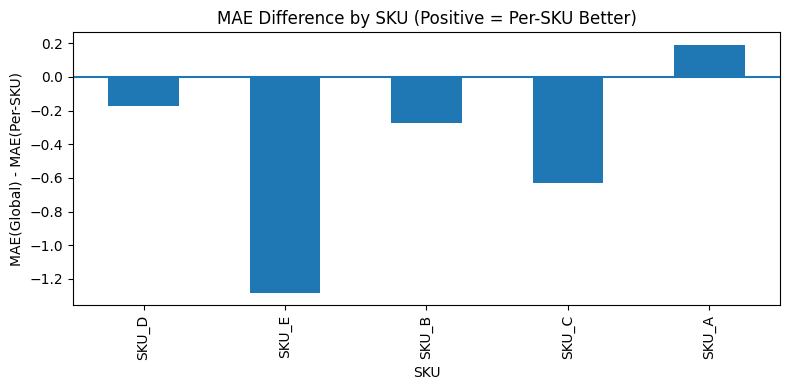

In [18]:
results_plot = results_df.set_index("SKU")

plt.figure(figsize=(8, 4))
results_plot["MAE Difference"].plot(kind="bar")
plt.axhline(0)
plt.ylabel("MAE(Global) - MAE(Per-SKU)")
plt.title("MAE Difference by SKU (Positive = Per-SKU Better)")
plt.tight_layout()
plt.show()


In [23]:
# ---- Add promotion events (synthetic) ----

df_ext = df_ext.copy()

# Create a promo flag initialized to 0
df_ext["promo_flag"] = 0

# Let's randomly pick a few promo windows per SKU
rng = np.random.default_rng(42)

for sku in df_ext["sku"].unique():
    # choose 3 promo periods per SKU
    promo_starts = rng.choice(df_ext["date"].unique(), size=3, replace=False)
    
    for start_date in promo_starts:
        # promo lasts 3 days
        promo_range = pd.date_range(start_date, periods=3)
        
        # Set flag
        df_ext.loc[
            (df_ext["sku"] == sku) & (df_ext["date"].isin(promo_range)),
            "promo_flag"
        ] = 1

# Now add promo demand spikes (20%–60% increase)
# Convert demand to float before modifying
df_ext["demand"] = df_ext["demand"].astype(float)

# Apply promo spikes safely
df_ext.loc[df_ext["promo_flag"] == 1, "demand"] *= rng.uniform(1.2, 1.6)


df_ext.head()


,date,sku,demand,dow,demand_lag1,demand_ma7,month,is_weekend,is_holiday,demand_lag7,ma7,ma14,promo_flag
0,2022-01-01,SKU_A,105.0,5,NaN,NaN,1,1,0,NaN,NaN,NaN,0
1,2022-01-02,SKU_A,100.0,6,105.0,NaN,1,1,0,NaN,NaN,NaN,0
2,2022-01-03,SKU_A,96.0,0,100.0,NaN,1,0,0,NaN,NaN,NaN,0
3,2022-01-04,SKU_A,120.0,1,96.0,NaN,1,0,0,NaN,NaN,NaN,0
4,2022-01-05,SKU_A,98.0,2,120.0,NaN,1,0,0,NaN,NaN,NaN,0


In [24]:
# ---- Extended feature set for multi-SKU forecasting ----

# Start from the original multi-SKU df (date, sku, demand)
df_ext = df.sort_values(["sku", "date"]).copy()

# Basic calendar features
df_ext["dow"] = df_ext["date"].dt.dayofweek           # day of week (0-6)
df_ext["month"] = df_ext["date"].dt.month
df_ext["is_weekend"] = df_ext["dow"].isin([5, 6]).astype(int)

# Very simple "holiday season" flag (Dec 24-31)
df_ext["is_holiday"] = (
    (df_ext["date"].dt.month == 12) &
    (df_ext["date"].dt.day >= 24)
).astype(int)

# Time-series features per SKU
grp = df_ext.groupby("sku")

# Lags
df_ext["demand_lag1"] = grp["demand"].shift(1)
df_ext["demand_lag7"] = grp["demand"].shift(7)

# Rolling means (using demand up to yesterday)
df_ext["ma7"] = grp["demand"].shift(1).rolling(7).mean().reset_index(level=0, drop=True)
df_ext["ma14"] = grp["demand"].shift(1).rolling(14).mean().reset_index(level=0, drop=True)

df_ext["promo_flag"] = 0
# add promo periods and spikes...
df_ext["demand"] = df_ext["demand"].astype(float)
df_ext.loc[df_ext["promo_flag"] == 1, "demand"] *= rng.uniform(1.2, 1.6)

# Drop rows that don't have enough history for these features
df2_ext = df_ext.dropna().reset_index(drop=True)

df2_ext.head()


,date,sku,demand,dow,demand_lag1,demand_ma7,month,is_weekend,is_holiday,demand_lag7,ma7,ma14,promo_flag
0,2022-01-15,SKU_A,82.0,5,110.0,104.428571,1,1,0,98.0,104.428571,102.071429,0
1,2022-01-16,SKU_A,111.0,6,82.0,102.142857,1,1,0,101.0,102.142857,100.428571,0
2,2022-01-17,SKU_A,105.0,0,111.0,103.571429,1,0,0,108.0,103.571429,101.214286,0
3,2022-01-18,SKU_A,103.0,1,105.0,103.142857,1,0,0,106.0,103.142857,101.857143,0
4,2022-01-19,SKU_A,88.0,2,103.0,102.714286,1,0,0,100.0,102.714286,100.642857,0


In [25]:
# One-hot encode SKU for the extended dataset
df2_ext_encoded = pd.get_dummies(df2_ext, columns=["sku"], drop_first=False)

# Time-based split (same idea: last 60 days as test)
cutoff_date_ext = df2_ext_encoded["date"].max() - pd.Timedelta(days=60)

train_ext = df2_ext_encoded[df2_ext_encoded["date"] < cutoff_date_ext].copy()
test_ext  = df2_ext_encoded[df2_ext_encoded["date"] >= cutoff_date_ext].copy()

len(train_ext), len(test_ext)


(3275, 305)

In [26]:
# Feature columns for extended model
feature_cols_ext = [
    "demand_lag1",
    "demand_lag7",
    "ma7",
    "ma14",
    "dow",
    "month",
    "is_weekend",
    "is_holiday",
] + [c for c in df2_ext_encoded.columns if c.startswith("sku_")]

X_train_ext = train_ext[feature_cols_ext]
y_train_ext = train_ext["demand"]

X_test_ext = test_ext[feature_cols_ext]
y_test_ext = test_ext["demand"]

from sklearn.ensemble import RandomForestRegressor

rf_multi_ext = RandomForestRegressor(
    n_estimators=400,
    max_depth=14,
    random_state=42,
    n_jobs=-1
)

rf_multi_ext.fit(X_train_ext, y_train_ext)
rf_ext_preds = rf_multi_ext.predict(X_test_ext)


In [27]:
# Make sure promo_flag exists in train_ext and test_ext

train_ext = train_ext.copy()
test_ext = test_ext.copy()

if "promo_flag" not in train_ext.columns or "promo_flag" not in test_ext.columns:
    # promo_flag lives in df2_ext, align by index
    train_ext.loc[:, "promo_flag"] = df2_ext.loc[train_ext.index, "promo_flag"].values
    test_ext.loc[:, "promo_flag"] = df2_ext.loc[test_ext.index, "promo_flag"].values


In [28]:
# ---- Promo-aware Extended Random Forest ----

rf_promo = RandomForestRegressor(
    n_estimators=400,
    max_depth=14,
    random_state=42,
    n_jobs=-1
)

# Include promo_flag in the feature set
feature_cols_promo = feature_cols_ext + ["promo_flag"]

X_train_promo = train_ext[feature_cols_promo]
y_train_promo = train_ext["demand"]

X_test_promo = test_ext[feature_cols_promo]
y_test_promo = test_ext["demand"]

rf_promo.fit(X_train_promo, y_train_promo)
rf_promo_preds = rf_promo.predict(X_test_promo)


In [29]:
# ---- Promo-aware XGBoost ----
from xgboost import XGBRegressor

xgb_promo = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_promo.fit(X_train_promo, y_train_promo)
xgb_promo_preds = xgb_promo.predict(X_test_promo)


In [30]:
from xgboost import XGBRegressor

# --- XGBoost model on extended features ---

xgb_ext = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_ext.fit(X_train_ext, y_train_ext)

xgb_ext_preds = xgb_ext.predict(X_test_ext)


In [31]:
global_promo_compare = pd.DataFrame([
    {
        "Model": "RF (Extended, No Promo Flag)",
        "MAE": mean_absolute_error(y_test_ext, rf_ext_preds),
        "MAPE": mape(y_test_ext, rf_ext_preds),
    },
    {
        "Model": "RF (Promo Aware)",
        "MAE": mean_absolute_error(y_test_promo, rf_promo_preds),
        "MAPE": mape(y_test_promo, rf_promo_preds),
    },
    {
        "Model": "XGB (Extended, No Promo Flag)",
        "MAE": mean_absolute_error(y_test_ext, xgb_ext_preds),
        "MAPE": mape(y_test_ext, xgb_ext_preds),
    },
    {
        "Model": "XGB (Promo Aware)",
        "MAE": mean_absolute_error(y_test_promo, xgb_promo_preds),
        "MAPE": mape(y_test_promo, xgb_promo_preds),
    }
])

global_promo_compare


,Model,MAE,MAPE
0,"RF (Extended, No Promo Flag)",7.285466,6.800572
1,RF (Promo Aware),7.274213,6.790214
2,"XGB (Extended, No Promo Flag)",7.572012,6.909958
3,XGB (Promo Aware),7.564865,6.974672


In [32]:
from sklearn.metrics import mean_absolute_error

# Reuse mape(y_true, y_pred)

rf_mae = mean_absolute_error(y_test_ext, rf_ext_preds)
rf_mape = mape(y_test_ext, rf_ext_preds)

xgb_mae = mean_absolute_error(y_test_ext, xgb_ext_preds)
xgb_mape = mape(y_test_ext, xgb_ext_preds)

xgb_global_comparison = pd.DataFrame([
    {
        "Model": "Extended RF (Global)",
        "MAE": rf_mae,
        "MAPE (%)": rf_mape
    },
    {
        "Model": "Extended XGBoost (Global)",
        "MAE": xgb_mae,
        "MAPE (%)": xgb_mape
    }
])

xgb_global_comparison


,Model,MAE,MAPE (%)
0,Extended RF (Global),7.285466,6.800572
1,Extended XGBoost (Global),7.572012,6.909958


In [33]:
# Ensure test_ext has sku + demand
test_ext = test_ext.copy()

# Reattach sku
if "sku" not in test_ext.columns:
    test_ext.loc[:, "sku"] = df2_ext.loc[test_ext.index, "sku"].values

test_ext.loc[:, "pred_rf_ext"] = rf_ext_preds
test_ext.loc[:, "pred_xgb_ext"] = xgb_ext_preds

per_sku_xgb_results = []

for sku_name in sorted(test_ext["sku"].unique()):
    df_sku = test_ext[test_ext["sku"] == sku_name]

    mae_rf  = mean_absolute_error(df_sku["demand"], df_sku["pred_rf_ext"])
    mae_xgb = mean_absolute_error(df_sku["demand"], df_sku["pred_xgb_ext"])

    mape_rf  = mape(df_sku["demand"], df_sku["pred_rf_ext"])
    mape_xgb = mape(df_sku["demand"], df_sku["pred_xgb_ext"])

    per_sku_xgb_results.append({
        "SKU": sku_name,
        "MAE (RF ext)": mae_rf,
        "MAE (XGB ext)": mae_xgb,
        "MAPE (RF ext)": mape_rf,
        "MAPE (XGB ext)": mape_xgb
    })

per_sku_xgb_df = pd.DataFrame(per_sku_xgb_results)

# Add which model is better per SKU
per_sku_xgb_df["Better Model (MAE)"] = np.where(
    per_sku_xgb_df["MAE (XGB ext)"] < per_sku_xgb_df["MAE (RF ext)"],
    "XGBoost",
    "Random Forest"
)

per_sku_xgb_df["MAE Improvement"] = (
    per_sku_xgb_df["MAE (RF ext)"] - per_sku_xgb_df["MAE (XGB ext)"]
)

per_sku_xgb_df.sort_values("MAE Improvement", ascending=False)


,SKU,MAE (RF ext),MAE (XGB ext),MAPE (RF ext),MAPE (XGB ext),Better Model (MAE),MAE Improvement
1,SKU_B,6.627538,6.002711,8.227776,7.458202,XGBoost,0.624827
3,SKU_D,6.157690,6.013637,6.129935,5.968956,XGBoost,0.144052
4,SKU_E,6.273136,6.393013,6.473048,6.604550,Random Forest,-0.119877
0,SKU_A,10.368391,11.290776,7.429442,8.030693,Random Forest,-0.922385
2,SKU_C,7.000576,8.159923,5.742660,6.487389,Random Forest,-1.159347


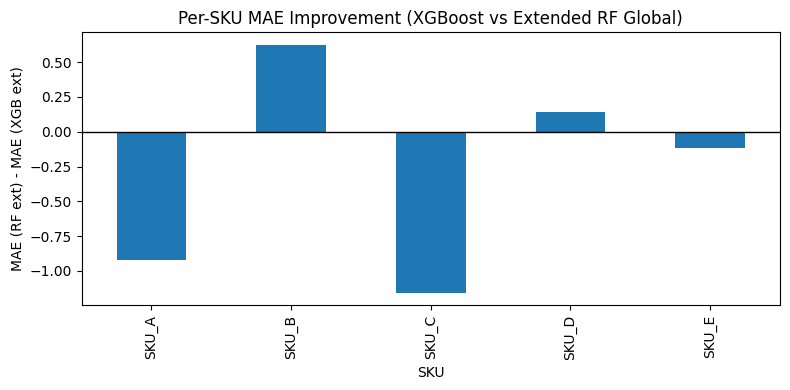

In [34]:
plot_xgb_df = per_sku_xgb_df.set_index("SKU")

plt.figure(figsize=(8, 4))
plot_xgb_df["MAE Improvement"].plot(kind="bar")
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("MAE (RF ext) - MAE (XGB ext)")
plt.title("Per-SKU MAE Improvement (XGBoost vs Extended RF Global)")
plt.tight_layout()
plt.show()


In [35]:
xgb_importances = pd.DataFrame({
    "feature": X_train_ext.columns,
    "importance": xgb_ext.feature_importances_
}).sort_values("importance", ascending=False)

xgb_importances.head(15)


,feature,importance
3,ma14,0.456475
2,ma7,0.153623
9,sku_SKU_B,0.058283
1,demand_lag7,0.045870
11,sku_SKU_D,0.044189
4,dow,0.041301
12,sku_SKU_E,0.040466
10,sku_SKU_C,0.039481
8,sku_SKU_A,0.030163
6,is_weekend,0.026409


In [36]:
from sklearn.metrics import mean_absolute_error

# Old global model metrics (from earlier experiment)
mae_global_old = mean_absolute_error(y_test, rf_preds)
mape_global_old = mape(y_test, rf_preds)

# New extended-feature global model metrics
mae_global_ext = mean_absolute_error(y_test_ext, rf_ext_preds)
mape_global_ext = mape(y_test_ext, rf_ext_preds)

global_comparison = pd.DataFrame([
    {
        "Model": "Original Global RF",
        "MAE": mae_global_old,
        "MAPE (%)": mape_global_old,
    },
    {
        "Model": "Extended-Feature Global RF",
        "MAE": mae_global_ext,
        "MAPE (%)": mape_global_ext,
    }
])

global_comparison


,Model,MAE,MAPE (%)
0,Original Global RF,7.487794,6.996330
1,Extended-Feature Global RF,7.285466,6.800572


In [37]:
# Reattach original 'sku' labels and add predictions for extended model
test_ext = test_ext.copy()
test_ext.loc[:, "sku"] = df2_ext.loc[test_ext.index, "sku"].values
test_ext.loc[:, "pred_ext_global"] = rf_ext_preds

# Also get old global predictions on the same indices, aligned
# (Use df2 to grab the right rows from your earlier test set)
old_test_global = test.copy()
old_test_global = old_test_global.reset_index()
old_test_global = old_test_global[["sku", "date", "demand", "pred"]].rename(
    columns={"demand": "actual", "pred": "pred_global_old"}
)

# Build a comparable frame for the extended model
ext_test_global = test_ext[["sku", "date", "demand", "pred_ext_global"]].rename(
    columns={"demand": "actual", "pred_ext_global": "pred_global_ext"}
)

# Merge on sku + date
compare_ext_df = ext_test_global.merge(
    old_test_global,
    on=["sku", "date", "actual"],
    how="inner"
)

compare_ext_df.head()


,sku,date,actual,pred_global_ext,pred_global_old
0,SKU_A,2023-11-01,128.0,137.135948,135.214161
1,SKU_A,2023-11-02,135.0,132.063453,131.612857
2,SKU_A,2023-11-03,132.0,131.924572,131.799767
3,SKU_A,2023-11-04,154.0,132.734063,128.726661
4,SKU_A,2023-11-05,127.0,128.967639,133.855452


In [38]:
per_sku_ext_results = []

for sku_name in sorted(compare_ext_df["sku"].unique()):
    df_sku = compare_ext_df[compare_ext_df["sku"] == sku_name]

    mae_old = mean_absolute_error(df_sku["actual"], df_sku["pred_global_old"])
    mae_ext = mean_absolute_error(df_sku["actual"], df_sku["pred_global_ext"])

    mape_old = mape(df_sku["actual"], df_sku["pred_global_old"])
    mape_ext = mape(df_sku["actual"], df_sku["pred_global_ext"])

    per_sku_ext_results.append({
        "SKU": sku_name,
        "MAE (Old Global)": mae_old,
        "MAE (Ext Global)": mae_ext,
        "MAPE (Old Global)": mape_old,
        "MAPE (Ext Global)": mape_ext,
    })

per_sku_ext_df = pd.DataFrame(per_sku_ext_results)

# Add improvement columns
per_sku_ext_df["MAE Improvement"] = per_sku_ext_df["MAE (Old Global)"] - per_sku_ext_df["MAE (Ext Global)"]
per_sku_ext_df["MAPE Improvement"] = per_sku_ext_df["MAPE (Old Global)"] - per_sku_ext_df["MAPE (Ext Global)"]

per_sku_ext_df.sort_values("MAE Improvement", ascending=False)


,SKU,MAE (Old Global),MAE (Ext Global),MAPE (Old Global),MAPE (Ext Global),MAE Improvement,MAPE Improvement
1,SKU_B,7.410334,6.627538,9.065182,8.227776,0.782796,0.837406
2,SKU_C,7.424914,7.000576,6.021391,5.742660,0.424337,0.278731
4,SKU_E,6.597780,6.273136,6.714880,6.473048,0.324644,0.241833
3,SKU_D,6.180273,6.157690,6.107790,6.129935,0.022583,-0.022145
0,SKU_A,9.825671,10.368391,7.072408,7.429442,-0.542720,-0.357034


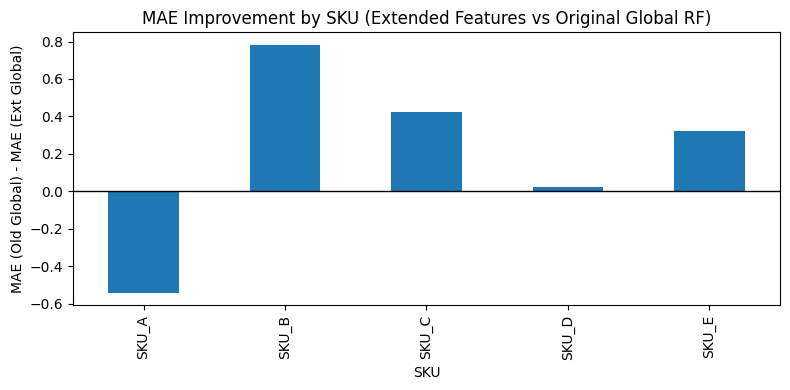

In [39]:
plot_df = per_sku_ext_df.set_index("SKU")

plt.figure(figsize=(8, 4))
plot_df["MAE Improvement"].plot(kind="bar")
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("MAE (Old Global) - MAE (Ext Global)")
plt.title("MAE Improvement by SKU (Extended Features vs Original Global RF)")
plt.tight_layout()
plt.show()


In [40]:
import os

os.makedirs("exports", exist_ok=True)

# Build a forecast panel for Power BI
panel = test_ext.copy()

panel["sku"] = df2_ext.loc[panel.index, "sku"].values
panel["date"] = df2_ext.loc[panel.index, "date"].values
panel["promo_flag"] = df2_ext.loc[panel.index, "promo_flag"].values
panel["actual"] = panel["demand"]

# Add predictions
panel["pred_rf_ext"] = rf_ext_preds
panel["pred_xgb_ext"] = xgb_ext_preds

# If promo-aware models trained, keep these:
# panel["pred_rf_promo"] = rf_promo_preds
# panel["pred_xgb_promo"] = xgb_promo_preds

# Select columns for Power BI
cols_for_bi = [
    "date",
    "sku",
    "actual",
    "promo_flag",
    "pred_rf_ext",
    "pred_xgb_ext",
    # "pred_rf_promo",
    # "pred_xgb_promo",
]

panel_bi = panel[cols_for_bi].sort_values(["sku", "date"]).reset_index(drop=True)

panel_bi.to_csv("exports/forecast_panel.csv", index=False)
panel_bi.head()


,date,sku,actual,promo_flag,pred_rf_ext,pred_xgb_ext
0,2023-11-01,SKU_A,128.0,0,137.135948,131.193970
1,2023-11-02,SKU_A,135.0,0,132.063453,129.088364
2,2023-11-03,SKU_A,132.0,0,131.924572,130.600983
3,2023-11-04,SKU_A,154.0,0,132.734063,124.433975
4,2023-11-05,SKU_A,127.0,0,128.967639,127.203506


In [41]:
panel_bi.to_csv("exports/forecast_panel.csv", index=False)


In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Load the panel we just exported
panel_bi = pd.read_csv("exports/forecast_panel.csv", parse_dates=["date"])

panel_bi.head()


,date,sku,actual,promo_flag,pred_rf_ext,pred_xgb_ext
0,2023-11-01,SKU_A,128.0,0,137.135948,131.193970
1,2023-11-02,SKU_A,135.0,0,132.063453,129.088360
2,2023-11-03,SKU_A,132.0,0,131.924572,130.600980
3,2023-11-04,SKU_A,154.0,0,132.734063,124.433975
4,2023-11-05,SKU_A,127.0,0,128.967639,127.203510


In [43]:
def mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error (in %).
    Avoid division by zero by replacing 0 with 1.
    """
    y_true_safe = y_true.replace(0, 1)
    return ((y_true_safe - y_pred).abs() / y_true_safe).mean() * 100

rows = []

for sku_name, g in panel_bi.groupby("sku"):
    y = g["actual"]

    # XGB metrics
    mae_xgb = mean_absolute_error(y, g["pred_xgb_ext"])
    mape_xgb = mape(y, g["pred_xgb_ext"])

    # RF metrics
    mae_rf = mean_absolute_error(y, g["pred_rf_ext"])
    mape_rf = mape(y, g["pred_rf_ext"])

    rows.append({
        "sku": sku_name,
        "mae_xgb_ext": mae_xgb,
        "mape_xgb_ext": mape_xgb,
        "mae_rf_ext": mae_rf,
        "mape_rf_ext": mape_rf,
    })

error_df = pd.DataFrame(rows)
error_df


,sku,mae_xgb_ext,mape_xgb_ext,mae_rf_ext,mape_rf_ext
0,SKU_A,11.290775,8.030693,10.368391,7.429442
1,SKU_B,6.002711,7.458202,6.627538,8.227776
2,SKU_C,8.159924,6.487389,7.000576,5.742660
3,SKU_D,6.013638,5.968956,6.157690,6.129935
4,SKU_E,6.393013,6.604550,6.273136,6.473048


In [44]:
os.makedirs("exports", exist_ok=True)

error_df.to_csv("exports/error_metrics_by_sku.csv", index=False)
error_df


,sku,mae_xgb_ext,mape_xgb_ext,mae_rf_ext,mape_rf_ext
0,SKU_A,11.290775,8.030693,10.368391,7.429442
1,SKU_B,6.002711,7.458202,6.627538,8.227776
2,SKU_C,8.159924,6.487389,7.000576,5.742660
3,SKU_D,6.013638,5.968956,6.157690,6.129935
4,SKU_E,6.393013,6.604550,6.273136,6.473048
